In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

In [7]:
def replace_and_convert(item: str, replace_map: dict={';': '', ':': ''}) -> float:
    '''
    Replace/delete special chars and then convert it to float
    '''
    try: 
        for k, v in replace_map.items():
            item = item.replace(k, v)
    except TypeError as e:
        print(e)
    try:
        return float(item)
    except ValueError:
        return np.NaN

def r2_coeff(arr1, arr2):
    '''
    Calculation of the coefficient of determination (R^2)
    '''
    y_mean = sum(arr1) / float(len(arr1))
    ss_tot = sum((yi - y_mean)**2 for yi in arr1)
    ss_err = sum((yi - fi)**2 for yi, fi in zip(arr1, arr2))
    r2 = 1 - (ss_err / ss_tot)
    return r2

def optimized_smoothing(df_col):
    '''
    Definition of a smoothing filter (Savitzky-Golay filter)
    '''
    # create array of df column
    arr = df_col.to_numpy()

    # define winsize (must be larger than polynomial order)
    winsize = 7

    # while loop to find "optimal" winsize
    while winsize < 100:
        # Savitzky-Golay filter for smoothing: array, window size, polynomial order
        smooth_arr = savgol_filter(arr, winsize, 2)

        # calculate R^2
        r2 = r2_coeff(arr, smooth_arr)
    
        # define abort criterion
        if r2 > 0.91:
            break
        elif winsize >= 15:
            break
        else:
            winsize += 2
        
    return smooth_arr, winsize, r2

def abw_spektr(name, df_path):
    '''
    Extract header informations and spectrum datat from csv-file
    '''
    # read the csv data set from waster water measuring station
    df = pd.read_csv(df_path, encoding = "ISO-8859-1", delimiter=':;', engine='python', header=None, on_bad_lines='skip')
    col_names = list(df.columns)

    # extract the CF factor from "header" (convert channels -> energies) and convert it to float
    CF = replace_and_convert(df.loc[df[col_names[0]] == 'Kalibrierfaktor', col_names[1]].iloc[0]) #Messzeit Spektrum (s):

    # extract the measuring time
    dt = replace_and_convert(df.loc[df[col_names[0]] == 'Messzeit Spektrum (s)', col_names[1]].iloc[0])
    print(dt)

    # get the index where the spectrum data begins
    idx = df.index[df[col_names[0]].str.contains(";Spektrum", case=False)]

    # start to load the spectrum data, set col names and split
    df_data = df.iloc[idx[0]:, 0].str.split(';', expand=True)
    df_data = df_data.reset_index(drop=True)
    df_data.columns = df_data.iloc[0]
    df_data = df_data.drop([0,1])

    # If zero spectrum has not yet been taken into account, then subtract it from the measured counts,
    # otherwise this has already been done automatically by the measuring station.
    if 'Nullspektrum' in col_names:
        df_data['Total'] = df_data['Spektrum'].astype(float) - df_data['Nullspektrum'].astype(float)
    else:
        df_data['Total'] = df_data['Spektrum'].astype(float)
    
    # set negative values to zero
    df_data[df_data['Total'] < 0] = 0

    # normalize
    df_data['Normalize'] = df_data['Total'] / df_data['Total'].sum()

    # smoothed
    df_data['Smoothed'], winsize, r2 = optimized_smoothing(df_data['Total'])
    df_data[df_data['Smoothed'] < 0] = 0

    print('\n---- {} ----'.format(name))
    print('CF spectrum {}: {}'.format(name, CF))
    print('Window size:', winsize)
    print('R^2:', round(r2, 3))
    print('---------------------')

    return df_data, CF, dt

In [3]:
py_path = os.getcwd()

data_path_lu177 = py_path + '/Data/Reference/AWM_Lu177_300Bq_3600s.csv'
data_path_lu177m_1 = py_path + '/Data/Reference/AWM_Lu177m_10000Bq_300s_160920.csv'
data_path_lu177m_2 = py_path + '/Data/Reference/AWM_Lu177m_7000Bq_3600s_040221.csv'
data_path_iod = py_path + '/Data/Reference/AWM_I131_7000Bq_3600s_170221.csv'

data_path_mix = py_path + '/Data/Mix_sample1/AWM_MIX_100vs100_3600s.csv'

In [8]:
df_Lu177_data, CF_Lu177, dt_Lu177 = abw_spektr('Lu177', data_path_lu177)
df_Lu177m_data_1, CF_Lu177m_1, dt_Lu177m_1 = abw_spektr('Lu177m', data_path_lu177m_1)
df_Lu177m_data_2, CF_Lu177m_2, dt_Lu177m_2 = abw_spektr('Lu177m', data_path_lu177m_2)
df_I131_data, CF_I131, dt_I131 = abw_spektr('I131', data_path_iod)

3600.0

---- Lu177 ----
CF spectrum Lu177: 0.46631
Window size: 7
R^2: 0.999
---------------------
300.0

---- Lu177m ----
CF spectrum Lu177m: 0.46796
Window size: 7
R^2: 0.999
---------------------
3600.0

---- Lu177m ----
CF spectrum Lu177m: 0.46111
Window size: 7
R^2: 1.0
---------------------
3600.0

---- I131 ----
CF spectrum I131: 0.46111
Window size: 7
R^2: 0.999
---------------------


Text(0.01, 0.85, 'B')

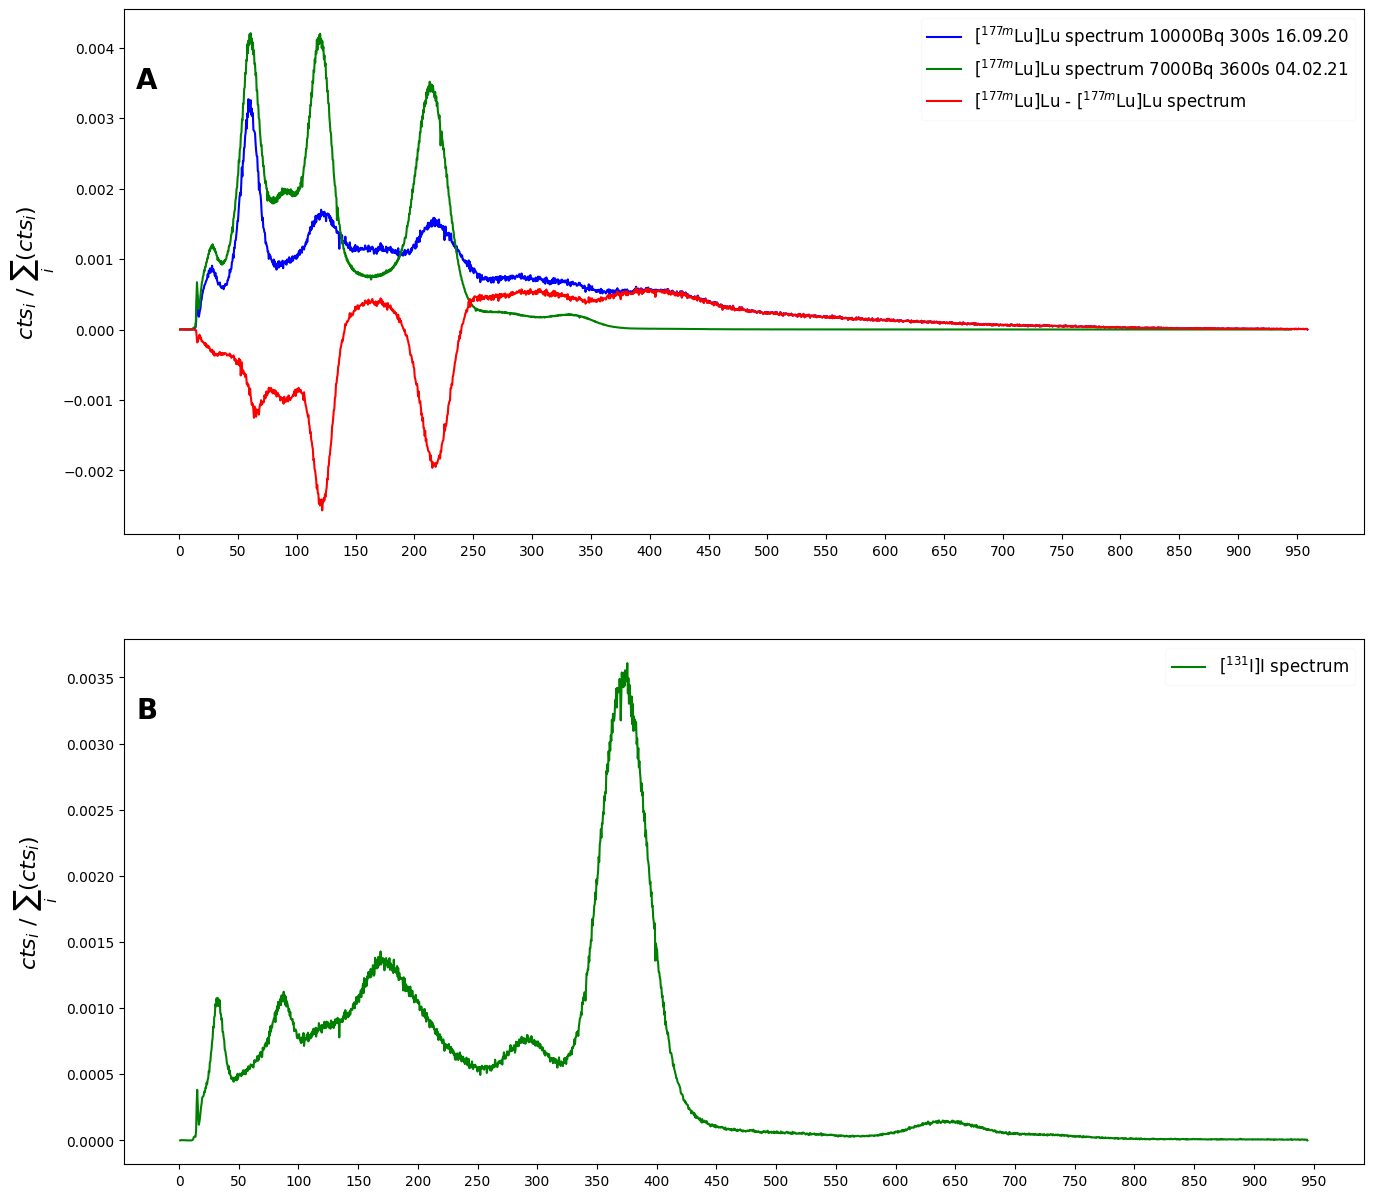

In [12]:
# define plots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(16, 15))

# spectra (normalized): comparison of Lu177m and Lu177
axs[0].plot(df_Lu177m_data_1.index * CF_Lu177m_1, df_Lu177m_data_1['Normalize'], color='blue', label='[$^{177m}$Lu]Lu spectrum 10000Bq 300s 16.09.20') 
axs[0].plot(df_Lu177m_data_2.index * CF_Lu177m_2, df_Lu177m_data_2['Normalize'], color='green', label='[$^{177m}$Lu]Lu spectrum 7000Bq 3600s 04.02.21')
axs[0].plot(df_Lu177m_data_1.index * CF_Lu177m_1, df_Lu177m_data_1['Normalize']-df_Lu177m_data_2['Normalize'], color='red', label='[$^{177m}$Lu]Lu - [$^{177m}$Lu]Lu spectrum')
axs[0].set_ylabel('$cts_i$ / $\sum_i(cts_i)$', fontsize=16)
axs[0].set_xticks(range(0,1000,50))
axs[0].legend(fancybox=True, framealpha=0.1, fontsize = 'large')
axs[0].text(0.01, 0.85, 'A', transform=axs[0].transAxes, size=20, weight='bold')

# I131 spectrum (normalized)
axs[1].plot(df_I131_data.index * CF_I131, df_I131_data['Normalize'], color='green', label='[$^{131}$I]I spectrum')
axs[1].set_ylabel('$cts_i$ / $\sum_i(cts_i)$', fontsize=16)
axs[1].set_xticks(range(0,1000,50))
axs[1].legend(fancybox=True, framealpha=0.1, fontsize = 'large')
axs[1].text(0.01, 0.85, 'B', transform=axs[1].transAxes, size=20, weight='bold')